In [328]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import euclidean_distances
import cvxpy as cp
import pandas as pd
from scipy.spatial.distance import pdist, squareform


## Implementation of Soft Margin SVC with RBF kernel

In this assigment you will implement a soft margin SVM problem on non- linear separable data. Many parts will be equivalent to last weeks assignment, only that the linear kernel $K_{lin}$ formulations must be replaced by the RBF kernel $K_{RBF}$.

This time the resulting classifier will be tested on unseen labeled data.

You will conduct parameter tuning as well as model selection for better results using scikit learns function.

### Training data set
Training data is the XOR dataset with labeled 40 samples.

**1. Add random noise with mean 0 and standard deviation 0.2**

In [329]:
np.random.seed(400)
X = np.random.randn(40, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
y= np.where(y, 1, -1)

# Your code here

noise = np.random.normal(0,0.2)
# print(y.shape)
# End your code

X =X+noise

### Test set for later use

**2. Generate 20 examples of XOR data. Use random seed ``800``.**

The test data will not be used until the SVM classification function is defined in task.


In [330]:
# Your code here
np.random.seed(800)
X_test = X[:20]
y_test = y[:20]

# End your code
# print(X_test)
# print(y_test)

###  Implementing the SVC task with RBF - Kernel.

In this task the kernel matrix $K_{rbf}$ with entries 

\begin{align}K(x_i, x_j)=\exp(-\gamma||x_i-x_j||²), \quad i,j \in 1,2,\cdots,N \end{align}

will be defined. First

**3. Define a function called ``pairwise_dists`` for arrays ``A``.** 

For the feature vector $X$ this function returns a matrix ``dist``  whose elements are the pairwise distances between all entries $x_i, x_j \in X.$

``dist``$  = \begin{bmatrix} 
    \|x_1-x_1\| & \|x_1-x_2\| &\dots \|x_1-x_N\|\\
    \vdots & \vdots &  \vdots \\
    \|x_N-x_1\| & \|x_N-x_2\|   &\dots \|x_N-x_N\| 
    \end{bmatrix}, 
$


where $\begin{align} \|x_i- x_j\|=\sqrt{\sum\limits_{i=1}^{N}(x_i- x_j)^2}\\
               \end{align}$. 


In [331]:
from scipy.spatial import distance_matrix
## Your code here.
def pairwise_dists(A):
    N = A.shape[0]                                     # Number of samples in X_train
    D = A.shape[1]                                 # Number of features in X_train
    dist =  np.zeros((N,N))                       # Initialize distance matrix using np.zeros
    for i in range(N):             # i is row index in matrix
        for j in range(N):         # j is the column index of matrix
            s = 0
            for k in range(D):
                s += (A[j,k] - A[i,k])** 2
            dist[i,j] = s**0.5
    return dist
## End your code
# pairwise_dists(X_test)

Compare the resulting ``dist`` to the matrix calculated with scikit learn function ``euclidian_distances``.


In [332]:
dist=euclidean_distances(X,X)
# dist-pairwise_dists(X)

**4. Define the RBF-kernel matrix ``K_rbf``with free parameter ``gamma``.**

See page 13 of lecture notes on part 2. 

Use the function defined in 3.

In [333]:
gamma=0.1

#Your code here
X_norm = np.sum(X ** 2, axis = -1)
K_rbf = np.exp(-gamma * (X_norm[:,None] + X_norm[None,:] - 2 * np.dot(X, X.T)))

# End your code

 **5. Define matrix $H$ and add ``epsilon`` to the diagonal.** 
 
Same prodecure as in task 5 of last week's assignment, only with the linear kernel replaced by the RBF kernel

In [334]:
y = y.reshape(-1,1) * 1. 
epsilon= 1e-5

## Your code here.

H =  y.T*K_rbf*y
H = H + np.identity(40)*epsilon

## End your code.

**6. Complete the definition of the convex optimization problem in CVXPY.**

Recycle the code from last weeks SVM assignment to define dual objective and constraints.

In the soft margin case you will need to implement the box constraint $0\leq\lambda_i\leq C$.

In [335]:
N = y.shape[0]
e = np.ones(N)
G = np.eye(N)
x = cp.Variable(N)*1.

C=1e5

# Your code here
dual_f = (1/2)*cp.quad_form(x,H) - (1/2)*e.T@x 
objective_non_lin = cp.Minimize(dual_f)
constraint_non_lin= [(y.T@x==0),(G@x>=0),(G@x<=C)]

# End your code

dual_problem_non_lin=cp.Problem(objective_non_lin, constraint_non_lin)
print("problem is DCP:", dual_problem_non_lin.is_dcp()) # false

problem is DCP: True


#### Solution of the SVM optimization problem.

In [336]:
dual_problem_non_lin.solve(solver=cp.OSQP)
print('The optimal value is', dual_problem_non_lin.value)

The optimal value is -4326.512789220808


**6. Complete the computation of the bias $b$.**

In [337]:
lambd=x.value
SV = (lambd > 1e-4).flatten()
support_vectors=X[SV]

y_lambda=y[SV].T*lambd[SV]

## Your code here. 

dist_supp = pairwise_dists(support_vectors)
K =X[SV]@X[SV].T

## End your code
K_dash=np.dot(y_lambda, K)
inner=y[SV]-K_dash.T

b=1/support_vectors.shape[0]*sum(inner)

Display 𝑏 and the number of Support Vectors.

In [338]:
print('The bias of the hyperplane b = ',b)
print('The Number of Support Vectors is',support_vectors.shape[0],'')
print('Number of Support Vectors in each class')
print (np.array([sum((y_lambda > 1e-4).flatten()),sum((y_lambda < 1e-4).flatten())]))

The bias of the hyperplane b =  [1.37802938]
The Number of Support Vectors is 6 
Number of Support Vectors in each class
[3 3]


**7. Define the ``svm_decision_function`` for unseen arrays ``u``**

See page 16 of SVM lecture part 2 and task 11. of last week's svm assignment.

**Vectorize**
\begin{align}
h(u):=\sum\limits_{\tau\in SV}\lambda_{\tau} y_{\tau} K_{RBF}(x_{\tau}, u) +b
\end{align}

Here use the scikit learn's ``euclidean_distances``.

In [339]:
# Your code here
def svm_decision_function(u):
    K_rbf = np.exp(-gamma * (euclidean_distances(X[SV],u)**2))
    #pairwise_dists = (pdist(X, 'euclidean'))
    #K = np.exp(-pairwise_dists ** 2 / s ** 2)
    #K = np.zeros((X[SV].shape[0],u.shape[0]))
    #for i,x in enumerate(X[SV]):
       # for j,y in enumerate(u):
           # K[i,j] = np.exp(-1*np.linalg.norm(u-X[SV])**2)
    return np.dot(y_lambda, K_rbf)+b

# End your code

**Run the next cell to see a viualization of your results.**

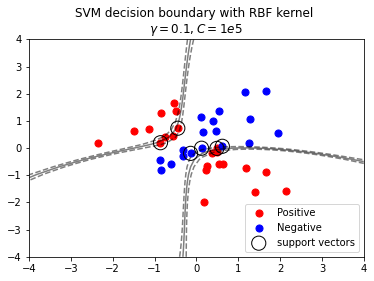

In [340]:
xx = np.linspace(-4,4,30) 
yy = np.linspace(-4, 4,30) 
y_1,x_1 = np.meshgrid(yy, xx) 
xy = np.vstack([x_1.ravel(), y_1.ravel()]).T

y=y.ravel()

h=svm_decision_function(xy).reshape(x_1.shape)
fig, ax = plt.subplots()

# plot decision boundary and margins
CS = ax.contour(x_1, y_1, h, colors='k',levels=[-1,0, 1],linestyles=['--', '-', '--'],alpha=0.5)

plt.scatter(X[y == 1, 0], X[y == 1, 1],s=50, marker = 'o', color = 'r', label = 'Positive')
plt.scatter(X[y == -1, 0],X[y == -1, 1],s=50, marker = 'o', color = 'b', label = 'Negative')
plt.scatter(support_vectors[:, 0],support_vectors[:, 1], s=200, linewidth=1, facecolors='none', edgecolors='black',label = 'support vectors')

plt.title('SVM decision boundary with RBF kernel \n' r'$\gamma=0.1, C=1e5$')
plt.legend(loc = 'lower right')
plt.show()

**8. Define the function ``svm_predictions`` for test data ``U``**

The function classifies unseen data by assigning the sign to each entry of the ``svm_decision_function``. 

Use the numpy function ``sign``.

Then store the predictions for unseen samples in the ``X_test`` in a variable called ``y_pred``.

In [341]:
## Your code here.

def svc_predictions(U):
    return np.sign(svm_decision_function(U))

y_pred=svc_predictions(X_test)
# print(y_pred.shape)
## End your code.

print('Predicted values are',y_pred.astype(int))

Predicted values are [[ 1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1  1 -1  1  1 -1 -1]]


The results can be displayed with a simple confusion matrikx using ``pandas.crosstab``.

**9. Flatten the arrays ``y_test`` and ``y_pred``.**


In [342]:
## Your code here

y_test=y_test.flatten()
y_pred= y_pred.flatten()

## End your code.


pd.crosstab(y_test, y_pred, rownames=['Observed'], colnames=['Predicted'], margins=True)

Predicted,-1.0,1.0,All
Observed,,,
-1,9,0,9
1,2,9,11
All,11,9,20


**10. Calculate prediction accuracy on test set with scikit learn's accuracy score.**

In [343]:
from sklearn.metrics import accuracy_score

## Your code here. 

test_acc=accuracy_score(y_test, y_pred)

## End your code.

print('Prediction accuracy on test set ist',test_acc)

Prediction accuracy on test set ist 0.9


### Enhancing the model

In terms of prediction accuracy, we cannot really be satisfied with the generalization result. Troubleshooting leaves us to decide wether we made a poor first choice on the cost parameter,the parameters of the chosen kernel or the chosen kernel itself. 

We can try to enhance our result by tuning 

1. The regularisation parameter ``C``
2. The model selection, here ``'rbf'`` vs. ``'poly'``
2. The kernel parameters ``gamma`` and ``degree`` 

The parameter grid to be searched is user defined. 



In [344]:
parameter_grid = {'C': [0.1, 1e1,1e2,1e3], 
              'gamma': [1,0.1,0.01],
              'degree':[2,3],
              'kernel': ['rbf', 'poly']}

Here we use grid search with a 6 fold cross validation to find the best parameters in the grid as defined above.

In [345]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),parameter_grid,cv=6,refit=True,verbose=1)
grid.fit(X,y)

Fitting 6 folds for each of 48 candidates, totalling 288 fits


GridSearchCV(cv=6, estimator=SVC(),
             param_grid={'C': [0.1, 10.0, 100.0, 1000.0], 'degree': [2, 3],
                         'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'poly']},
             verbose=1)

In [346]:
print('Best model found for the data is',grid.best_estimator_)

Best model found for the data is SVC(C=10.0, degree=2, gamma=1)


**11. Fit the training data with the best set of parameters found above.**

In [347]:
## Your code here.
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=20,random_state = 0)
model = SVC(C=10,kernel='rbf',gamma=1,degree=2)

  ## fit the model here
model.fit(X,y)
## End your code

SVC(C=10, degree=2, gamma=1)

**12. Calculate training accuracy**

In [348]:
## Your code here.
y_pred_train = svc_predictions(X_train)
y_pred_train = y_pred_train.reshape((-1,1))
# print(y_pred_train.shape)
# print(y_train.shape)
train_accuracy= accuracy_score(y_train, y_pred_train)

## End your code

print('Training accuracy with best parameter set is ', train_accuracy)

Training accuracy with best parameter set is  0.85


**13. Calculate test accuracy**

In [349]:
## Your code here

y_pred_test = svc_predictions(X_test)
y_pred_test = y_pred_test.reshape((-1,1))
test_accuracy= accuracy_score(y_test, y_pred_test)

## End your code

print('Testing accuracy with best parameter set is ', test_accuracy)

Testing accuracy with best parameter set is  0.95


**14. Interpret the results.**